<a href="https://colab.research.google.com/github/harikrish2727/Simplilearn-AI-capstone-project-on-amazon-product-reviews/blob/main/Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-commerce

This dataset of amazon product reviews is highly imbalanced, most data is positive reviews. Here I have done data visualization first and then sentiment analysis using tf-idf vectorizer, word embeding using tensorflow, pretrained word vectors, also created word vectors from the dataset. Also done topic modeling.

### Import Libraries

### NLP Libraries

In [ ]:
import gensim
import spacy
import nltk
import en_core_web_sm
import en_core_web_md

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer,PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,classification_report,RocCurveDisplay,roc_curve,plot_roc_curve,plot_precision_recall_curve
from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD,NMF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,StackingClassifier,VotingClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold,StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Input,BatchNormalization,LSTM,GRU,GlobalMaxPooling1D,Embedding,Bidirectional,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")

**Downloading stopwords**

In [ ]:
from spacy.lang.en import STOP_WORDS
punc = string.punctuation
stop_words = list(STOP_WORDS)+list(punc)

In [ ]:
"not" in stop_words

True

In [ ]:
stop_words.remove("not")   #not is included in stopwords, in reviews not is very important, so removing from stopwords

In [ ]:
"not" in stop_words

False

# Reading Data

In [ ]:
df_train       = pd.read_csv("train_data.csv")  
df_test        = pd.read_csv("test_data.csv")
df_test_hidden = pd.read_csv("test_data_hidden.csv")

In [ ]:
df_train.shape,df_test.shape

((4000, 8), (1000, 7))

# Project Task: Week 1

# 1. Perform an EDA on the dataset.

In [ ]:
df_train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [ ]:
df_train.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [ ]:
df_train.shape

(4000, 8)

In [ ]:
df_train.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [ ]:
df_train["sentiment"].head()

0    Positive
1    Positive
2     Neutral
3    Positive
4    Positive
Name: sentiment, dtype: object

# class imbalance 

In [ ]:
df_train.sentiment.value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

**very much imbalanced data**

In [ ]:
df_train.sentiment.value_counts(normalize=True)*100

Positive    93.725
Neutral      3.950
Negative     2.325
Name: sentiment, dtype: float64

**more than 90% of data is positive reviews**

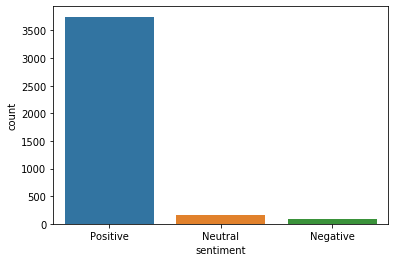

In [ ]:
sns.countplot(df_train.sentiment)

In [ ]:
sample = df_train["reviews.text"][0]   #just a sample review

In [ ]:
sample

'Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money'

In [ ]:
data = df_train[["reviews.text","sentiment"]]         #taking useful cols

In [ ]:
data.head()

,reviews.text,sentiment
0,Purchased on Black FridayPros - Great Price (e...,Positive
1,I purchased two Amazon in Echo Plus and two do...,Positive
2,Just an average Alexa option. Does show a few ...,Neutral
3,"very good product. Exactly what I wanted, and ...",Positive
4,This is the 3rd one I've purchased. I've bough...,Positive


In [ ]:
sample_positive_review = data[data["sentiment"]=="Positive"]["reviews.text"][0]
sample_positive_review

'Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money'

In [ ]:
sample_neg_review = data[data["sentiment"]=="Negative"]["reviews.text"][9]
sample_neg_review

'was cheap, can not run chrome stuff, returned to store.'

In [ ]:
sample_neutral_review = data[data["sentiment"]=="Neutral"]["reviews.text"][2]
sample_neutral_review

'Just an average Alexa option. Does show a few things on screen but still limited.'

#  Neutral Reviews

In [ ]:
neutral_reviews = pd.DataFrame(data[data["sentiment"]=="Neutral"]["reviews.text"]).reset_index(drop=True)
neutral_reviews.head()

,reviews.text
0,Just an average Alexa option. Does show a few ...
1,My 7-year old daughter saved up to by this. He...
2,"Not as good as before the old kindle, just sea..."
3,There is nothing spectacular about this item b...
4,It's unfair for me to rate this product cause ...


In [ ]:
neutral_reviews_text = " ".join(neutral_reviews["reviews.text"])

## word cloud on neutral reviews

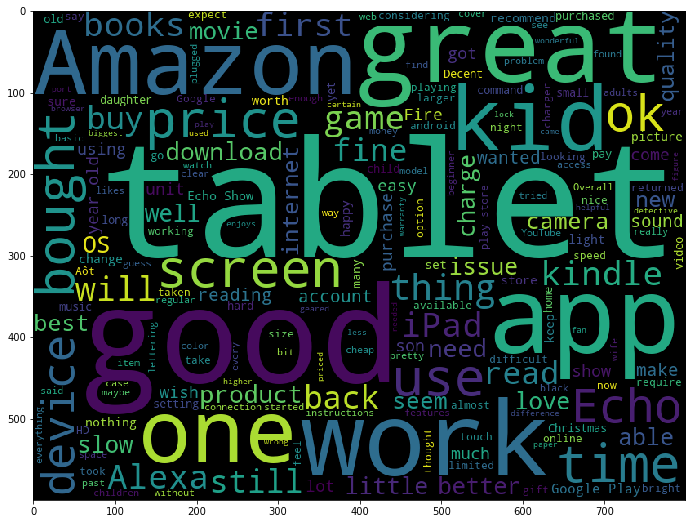

In [ ]:
plt.figure(figsize=(18,9))
cloud = WordCloud(width=800,height=600).generate_from_text(neutral_reviews_text)
plt.imshow(cloud)

## Positive Reviews

In [ ]:
positive_reviews = pd.DataFrame(data[data["sentiment"]=="Positive"]).reset_index(drop=True)
positive_reviews.head()

,reviews.text,sentiment
0,Purchased on Black FridayPros - Great Price (e...,Positive
1,I purchased two Amazon in Echo Plus and two do...,Positive
2,"very good product. Exactly what I wanted, and ...",Positive
3,This is the 3rd one I've purchased. I've bough...,Positive
4,This is a great product. Light weight. I wish ...,Positive


In [ ]:
positive_reviews_text = " ".join(positive_reviews["reviews.text"])
positive_reviews_text

'Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money I purchased two Amazon in Echo Plus and two dots plus four fire sticks and the hub Philips hue for lamp for the family at Christmas 2017. I‚Äôm so happy with these purchases and learning so much with Alexa. You can start your daily routine with Alexa and program it to whatever you would like to include news weather music horoscope ALSO you can start your day off with a compliment and I think is very important. Alexa gave me the BEST CHILI RECIPE I MEAN THE BEST it‚Äôs called Chili I. I want my husband to use Alexa to stay organized for business dates and reminders. This is the way t

# Word cloud on Positive text

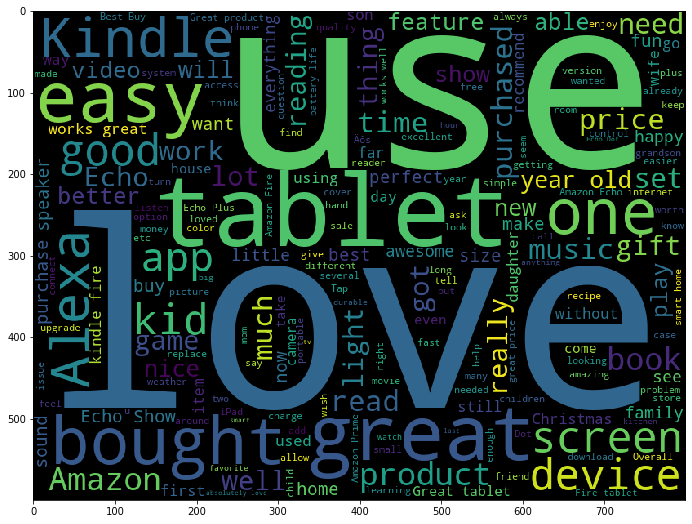

In [ ]:
plt.figure(figsize=(18,9))
cloud = WordCloud(width=800,height=600).generate_from_text(positive_reviews_text)
plt.imshow(cloud)

## Negative Reviews

In [ ]:
negative_reviews = pd.DataFrame(data[data["sentiment"]=="Negative"]).reset_index(drop=True)
negative_reviews.head()

,reviews.text,sentiment
0,"was cheap, can not run chrome stuff, returned ...",Negative
1,"Worthless, except as a regular echo and a poor...",Negative
2,Too bad Amazon turned this tablet into a big a...,Negative
3,I bought this Kindle for my 7 year old grand-d...,Negative
4,I am reading positive reviews and wish I could...,Negative


In [ ]:
negative_reviews_text = " ".join(negative_reviews["reviews.text"])
negative_reviews_text

'was cheap, can not run chrome stuff, returned to store. Worthless, except as a regular echo and a poor excuse for video chat. I love my echo devices, bathroom, pool, kitchen, other places where I may need hands free, voice activated music and info. My wife bought me the \'newest, hottest\' thing. I was skeptical but then thought I would use it to help on a project. Me "Alexa find videos on f450 drone" Alexa "YouTube is not available". Amazon won\'t directly sell chrome products, youtube won\'t play on echo show. Further testing shows the video call is more limited than iPhone or Android apps for video. So the most useful thing now is the same voice functions that my echos and dots perform. Unless I want to make all of my video calls and check the weather from a device I can move no more than 3 feet from an outlet. Too bad Amazon turned this tablet into a big advertising tool. Many apps dont work and the camera is not good. I bought this Kindle for my 7 year old grand-daughter. I bough

## Word Cloud on Negative reviews

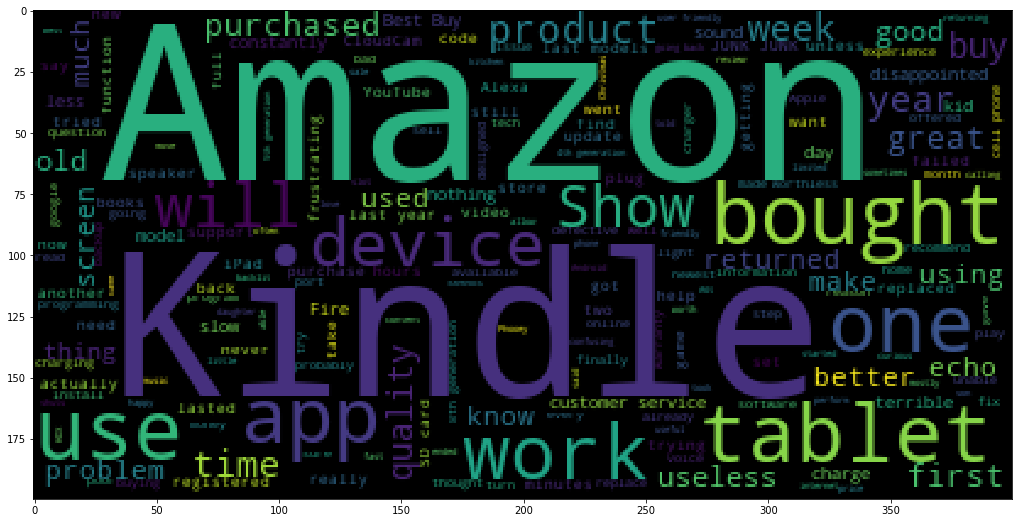

In [ ]:
plt.figure(figsize=(18,9))
cloud = WordCloud().generate_from_text(negative_reviews_text)
plt.imshow(cloud)

In [ ]:
X = data["reviews.text"]
y = data["sentiment"]

In [ ]:
lema = WordNetLemmatizer()

**data cleaning**

In [ ]:
cleaned = []
tag = {}
for i in X:
    review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ",i)  #url removal
    review = re.sub("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"," ",review)                          #mail id removal
    review = re.sub(r"[^a-zA-Z ]"," ",review)
    review = review.lower()
    review = word_tokenize(review)
    review = [lema.lemmatize(word) for word in review if word not in set(stop_words)]
    for key,val in nltk.pos_tag(review):
        tag[key]=val
    #tag.append(pos)
    cleaned.append(" ".join(review))

In [ ]:
len(cleaned)

4000

In [ ]:
len(tag)

4046

In [ ]:
tag

{'purchased': 'VBD',
 'black': 'JJ',
 'fridaypros': 'RB',
 'great': 'JJ',
 'price': 'NN',
 'sale': 'NN',
 'powerful': 'JJ',
 'fast': 'RBR',
 'quad': 'NN',
 'core': 'NN',
 'processor': 'NN',
 'amazing': 'VBG',
 'soundwell': 'NN',
 'builtcons': 'NNS',
 'amazon': 'NN',
 'ad': 'NN',
 'need': 'JJ',
 'subsidize': 'VB',
 'tablet': 'NN',
 'remove': 'VB',
 'add': 'VB',
 'pay': 'NN',
 'inability': 'NN',
 'access': 'NN',
 'apps': 'IN',
 'one': 'CD',
 'way': 'NN',
 'able': 'JJ',
 'accomplish': 'JJ',
 'google': 'NN',
 'play': 'NN',
 'storenet': 'NN',
 'money': 'NN',
 'echo': 'NN',
 'plus': 'CC',
 'dot': 'NN',
 'fire': 'NN',
 'stick': 'NN',
 'hub': 'JJ',
 'philip': 'NN',
 'hue': 'NN',
 'lamp': 'NN',
 'family': 'NN',
 'christmas': 'NN',
 'm': 'NN',
 'happy': 'JJ',
 'purchase': 'NN',
 'learning': 'VBG',
 'alexa': 'NN',
 'start': 'VB',
 'daily': 'JJ',
 'routine': 'JJ',
 'program': 'NN',
 'like': 'IN',
 'include': 'VBP',
 'news': 'NN',
 'weather': 'JJ',
 'music': 'NN',
 'horoscope': 'JJ',
 'day': 'NN',


In [ ]:
cleaned[0]      #sample cleaned review

'purchased black fridaypros great price sale powerful fast quad core processor amazing soundwell builtcons amazon ad amazon need subsidize tablet remove add pay inability access apps one amazon way able accomplish add google play storenet great tablet money'

# Extracting Nouns from reviews

In [ ]:
nouns = [(i,j) for i,j in tag.items() if any(noun_tag in j for noun_tag in ["NN","NP"])]

In [ ]:
nouns[:20]

[('price', 'NN'),
 ('sale', 'NN'),
 ('quad', 'NN'),
 ('core', 'NN'),
 ('processor', 'NN'),
 ('soundwell', 'NN'),
 ('builtcons', 'NNS'),
 ('amazon', 'NN'),
 ('ad', 'NN'),
 ('tablet', 'NN'),
 ('pay', 'NN'),
 ('inability', 'NN'),
 ('access', 'NN'),
 ('way', 'NN'),
 ('google', 'NN'),
 ('play', 'NN'),
 ('storenet', 'NN'),
 ('money', 'NN'),
 ('echo', 'NN'),
 ('dot', 'NN')]

In [ ]:
cloud = WordCloud().generate(" ".join(nouns))

# word cloud of Nouns

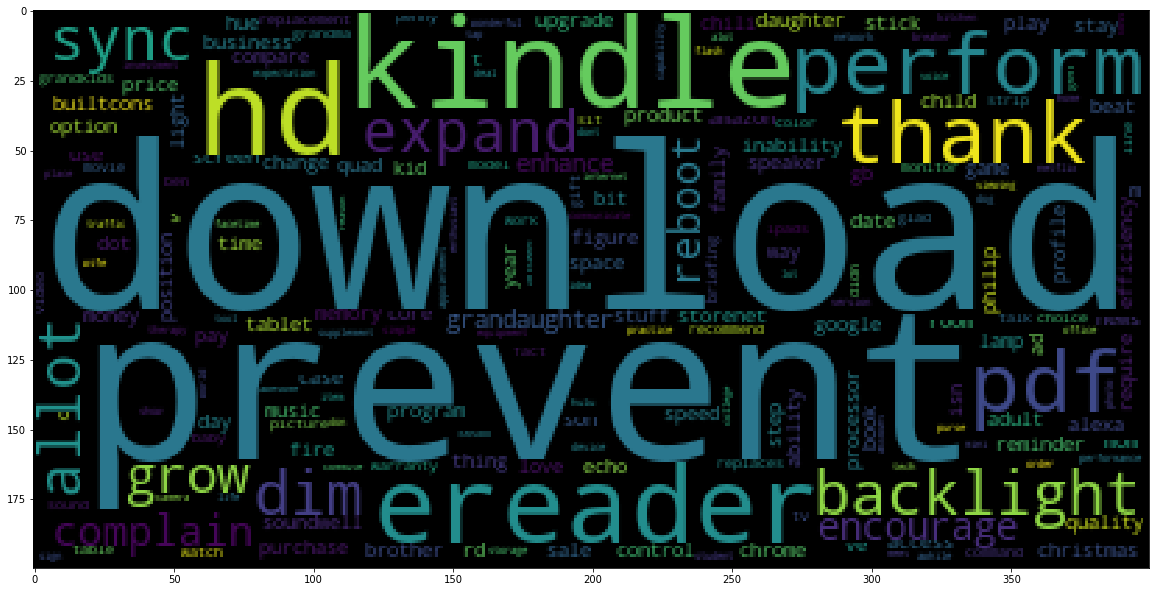

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(cloud)

## Extracting Verbs from reviews

In [ ]:
verbs = [(i,j) for i,j in tag.items() if any (verb_tag in j for verb_tag in["VBG","VBD","VB","VBN","VBP"])]

In [ ]:
verbs

[('purchased', 'VBD'),
 ('amazing', 'VBG'),
 ('subsidize', 'VB'),
 ('remove', 'VB'),
 ('add', 'VB'),
 ('learning', 'VBG'),
 ('start', 'VB'),
 ('include', 'VBP'),
 ('think', 'VBP'),
 ('gave', 'VBD'),
 ('called', 'VBD'),
 ('want', 'VBP'),
 ('husband', 'VBP'),
 ('organized', 'VBN'),
 ('wanted', 'VBD'),
 ('bought', 'VBD'),
 ('held', 'VBN'),
 ('protected', 'VBD'),
 ('dropping', 'VBG'),
 ('wifi', 'VBD'),
 ('saved', 'VBD'),
 ('needed', 'VBD'),
 ('priced', 'VBN'),
 ('considering', 'VBG'),
 ('located', 'VBN'),
 ('wanting', 'VBG'),
 ('run', 'VBP'),
 ('got', 'VBD'),
 ('replace', 'VB'),
 ('came', 'VBD'),
 ('aging', 'VBG'),
 ('set', 'VBN'),
 ('built', 'VBD'),
 ('noticed', 'VBD'),
 ('given', 'VBN'),
 ('planning', 'VBG'),
 ('getting', 'VBG'),
 ('exceed', 'VBP'),
 ('keep', 'VB'),
 ('carry', 'VBP'),
 ('waiting', 'VBG'),
 ('listen', 'VBP'),
 ('enjoys', 'VBZ'),
 ('buy', 'VB'),
 ('implemented', 'VBN'),
 ('connected', 'VBN'),
 ('having', 'VBG'),
 ('running', 'VBG'),
 ('streaming', 'VBG'),
 ('updated', 'VBD

In [ ]:
verbs = [i for i,j in verbs]

In [ ]:
cloud = WordCloud()

# word cloud of Verbs

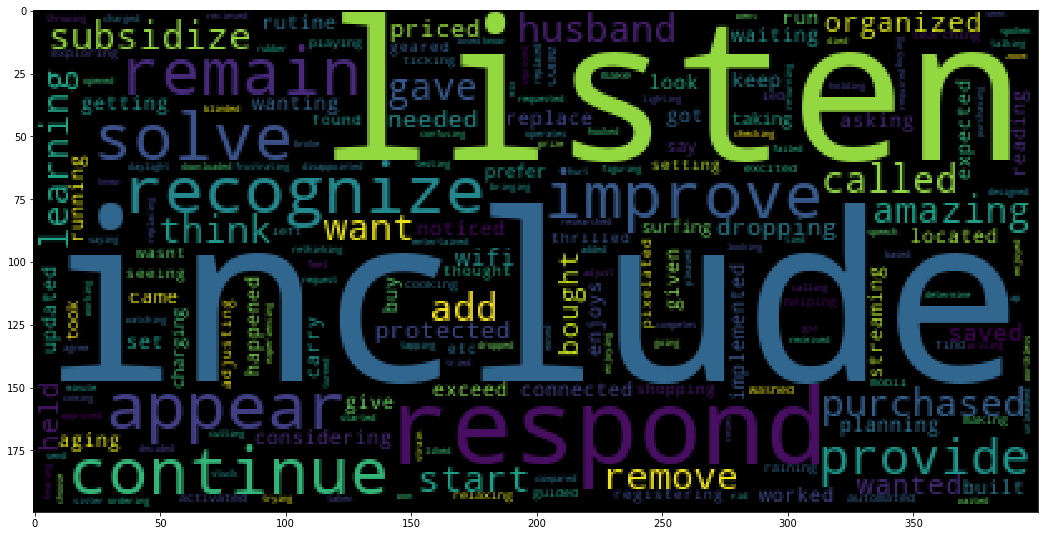

In [ ]:
plt.figure(figsize=(18,12))
plt.imshow(cloud.generate(" ".join(verbs)))

# Crreating TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer(analyzer="word",ngram_range=(1,3),stop_words={"english"})

In [ ]:
X = vectorizer.fit_transform(cleaned).toarray()

In [ ]:
dataframe = pd.DataFrame(X,columns=vectorizer.get_feature_names())

C:\Users\Vishnu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dataframe.head()

,abc,abc mouse,abc mouse downloaded,abc mouse hit,abc mouse us,ability,ability add,ability add gb,ability add library,ability adjust,...,zinio work amazon,zippy,zippy screen,zippy screen clarity,zone,zone installed,zone installed abc,zoom,zoom little,zoom little kindle
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
full_dataframe = pd.concat([dataframe,y],axis=1)

In [ ]:
full_dataframe.head()

,abc,abc mouse,abc mouse downloaded,abc mouse hit,abc mouse us,ability,ability add,ability add gb,ability add library,ability adjust,...,zippy,zippy screen,zippy screen clarity,zone,zone installed,zone installed abc,zoom,zoom little,zoom little kindle,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


mapping reviews to -1,0,1

In [ ]:
y

0       Positive
1       Positive
2        Neutral
3       Positive
4       Positive
          ...   
3995    Positive
3996    Positive
3997    Positive
3998    Positive
3999    Positive
Name: sentiment, Length: 4000, dtype: object

In [ ]:
 y = y.map({"Positive":2,'Neutral':1,"Negative":0})

In [ ]:
# X = full_dataframe.drop("sentiment",axis=1)
# y = full_dataframe["sentiment"]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(dataframe,y,test_size=.25,random_state=3)

# Multinomial Naive bayes

In [ ]:
multi = MultinomialNB()

In [ ]:
multi.fit(X_train,y_train)

MultinomialNB()

In [ ]:
y_pred = multi.predict(X_test)

In [ ]:
print(accuracy_score(y_test,y_pred))

0.943


In [ ]:
confusion_matrix(y_test,y_pred)

array([[  0,   0,  24],
       [  0,   0,  33],
       [  0,   0, 943]], dtype=int64)

#### Everything is predicted as positive,because the dataset is highly imbalanced

### Test dataset

In [ ]:
test_reviews = df_test["reviews.text"]

In [ ]:
cleaned = []
for i in test_reviews:
    review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ",i)  #url removal
    review = re.sub("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"," ",review)                          #mail id removal
    review = re.sub(r"[^a-zA-Z ]"," ",review)
    review = review.lower()
    review = word_tokenize(review)
    review = [lema.lemmatize(word) for word in review if word not in set(stop_words)]
    cleaned.append(" ".join(review))

In [ ]:
test = vectorizer.transform(cleaned)

In [ ]:
test_pred = multi.predict(test.toarray())

C:\Users\Vishnu\anaconda3\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
y_test_true = df_test_hidden["sentiment"].map({"Positive":2,'Neutral':1,"Negative":0})

In [ ]:
accuracy_score(y_test_true,test_pred)

0.937

In [ ]:
confusion_matrix(y_test_true,test_pred)

array([[  0,   0,  24],
       [  0,   0,  39],
       [  0,   0, 937]], dtype=int64)

### Every prediction by model was Postive because the dataset is highly imbalanced 

# Week 2

# Handling Class Imbalance problem

In [ ]:
train_data = df_train[["reviews.text","sentiment"]]
X = train_data["reviews.text"]
y = train_data["sentiment"]

In [ ]:
X_test = df_test["reviews.text"]

In [ ]:
y_test = df_test_hidden["sentiment"]

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
def clean_text(text):
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if token.lemma_!="-PRON-":                  #lematizing gives output as pronouns,just avoiding that
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower()
        tokens.append(temp)
    
    cleaned = []
    for i in tokens:
        if i not in stop_words:
            review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ",i)  #urls
            review = re.sub("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"," ",review)                            #e-mail
            review = re.sub(r"[^a-zA-Z ]"," ",review)
            #cleaned.append(" ".join(review))
            cleaned.append(review)
    
    return cleaned

#### sample 

In [ ]:
example_text = "This is a sample text for demonstration purpose"

In [ ]:
clean_text(example_text)

['sample', 'text', 'demonstration', 'purpose']

#### mapping categorical values

In [ ]:
y = y.map({"Negative":0,"Neutral":1,"Positive":2})

In [ ]:
y_test = y_test.map({"Negative":0,"Neutral":1,"Positive":2})

#### Train test split

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.25,random_state=36)

### TF-IDF Vectorizer

In [ ]:
tfidf = TfidfVectorizer(tokenizer=clean_text)

#### fitting on training data

In [ ]:
tfidf.fit(X_train)

TfidfVectorizer(tokenizer=<function clean_text at 0x0000023A467259D8>)

#### transforming

In [ ]:
X_train  = tfidf.transform(X_train).toarray()

In [ ]:
X_valid  = tfidf.transform(X_valid).toarray()

In [ ]:
X_test  = tfidf.transform(X_test).toarray()

In [ ]:
X_train.shape,X_valid.shape,X_test.shape

((3000, 3391), (1000, 3391), (1000, 3391))

In [ ]:
y_train.shape,y_valid.shape,y_test.shape

((3000,), (1000,), (1000,))

##  Running Multinomial Naivebayes

In [ ]:
multi = MultinomialNB()
multi.fit(X_train,y_train)
train_pred = multi.predict(X_train)
valid_pred = multi.predict(X_valid)

In [ ]:
test_pred = multi.predict(X_test)

In [ ]:
accuracy_score(y_train,train_pred)

0.937

In [ ]:
confusion_matrix(y_train,train_pred)

array([[   0,    0,   76],
       [   0,    0,  113],
       [   0,    0, 2811]], dtype=int64)

In [ ]:
f1_score(y_train,train_pred,average=None)

array([0.        , 0.        , 0.96747548])

In [ ]:
accuracy_score(y_valid,valid_pred)

0.938

In [ ]:
confusion_matrix(y_test,test_pred)

array([[  0,   0,  24],
       [  0,   0,  39],
       [  0,   0, 937]], dtype=int64)

# Oversampling using Smote

In [ ]:
smote = SMOTE()

###  The dimension will be very high after doing smote on transformed data, so doing Dimensionality Reduction

## Non Negative Matrix Factorization

In [ ]:
nmf = NMF(n_components=500)

In [ ]:
X_train_new = nmf.fit_transform(X_train)

In [ ]:
X_valid_new = nmf.transform(X_valid)

In [ ]:
X_test_new  = nmf.transform(X_test)

In [ ]:
X_train_new.shape,X_valid_new.shape,X_test_new.shape

((3000, 500), (1000, 500), (1000, 500))

In [ ]:
y_train.shape

(3000,)

In [ ]:
y_train.value_counts()

2    2811
1     113
0      76
Name: sentiment, dtype: int64

# Resampling using Smote on reduced data

In [ ]:
X_train_re,y_train_re = smote.fit_resample(X_train_new,y_train)

In [ ]:
y_train_re.shape

(8433,)

In [ ]:
y_train_re.value_counts()

2    2811
1    2811
0    2811
Name: sentiment, dtype: int64

## Modeling on resampled data

In [ ]:
def estimator(algo,trainx,trainy,validx,validy,testx,testy):
    
    algo.fit(trainx,trainy)
    
    train_pred = algo.predict(trainx)
    valid_pred = algo.predict(validx)
    test_pred  = algo.predict(testx)
    
    return train_pred,valid_pred,test_pred

def scoring(trainy,train_pred,validy,valid_pred,testy,test_pred):
    
    print(f"accuracy on train data:      {accuracy_score(trainy,train_pred)}")
    print(f"accuracy on validation data: {accuracy_score(validy,valid_pred)}")
    print(f"accuracy on test data:       {accuracy_score(testy,test_pred)}")
    
    print(f"f1 score on train data:      {f1_score(trainy,train_pred,average=None)}")
    print(f"f1 score on train data:      {f1_score(validy,valid_pred,average=None)}")
    print(f"f1 score on train data:      {f1_score(testy,test_pred,average=None)}")

## Multinomial Naive Bayes on Over Sampled Data

In [ ]:
multi = MultinomialNB()

In [ ]:
train_pred,valid_pred,test_pred = estimator(multi,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.8770307126763903
accuracy on validation data: 0.747
accuracy on test data:       0.735
f1 score on train data:      [0.91690937 0.87623932 0.83297934]
f1 score on train data:      [0.17391304 0.18779343 0.8576555 ]
f1 score on train data:      [0.19047619 0.17272727 0.85126965]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2676,   76,   59],
       [  96, 2563,  152],
       [ 254,  400, 2157]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[ 10,   5,   2],
       [ 10,  20,  15],
       [ 78, 143, 717]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 12,   8,   4],
       [ 11,  19,   9],
       [ 79, 154, 704]], dtype=int64)

### F1 Scoreson each classes Improved after smote

# Decision tree Classifier

In [ ]:
tree = DecisionTreeClassifier()

In [ ]:
train_pred,valid_pred,test_pred = estimator(tree,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      1.0
accuracy on validation data: 0.872
accuracy on test data:       0.884
f1 score on train data:      [1. 1. 1.]
f1 score on train data:      [0.26666667 0.29824561 0.93318609]
f1 score on train data:      [0.30769231 0.29126214 0.94227598]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2811,    0,    0],
       [   0, 2811,    0],
       [   0,    0, 2811]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[ 10,   2,   5],
       [  5,  17,  23],
       [ 43,  50, 845]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 12,   3,   9],
       [  8,  15,  16],
       [ 34,  46, 857]], dtype=int64)

### Decision tree performed way better than Multinomial Naive Bayes

## Using GridSearchCV with decision tree

In [ ]:
params = {"criterion":['gini',"entropy"],
         "max_depth":[3,4,5],
         "min_samples_split":[2,3,4],
         "min_samples_leaf":[1,2,3],
         "min_weight_fraction_leaf":[0.0,0.01,0.1,0.5],
         "ccp_alpha":[0.01,0.1,1,10]}

In [ ]:
grid = GridSearchCV(estimator=tree,param_grid=params,cv=5,n_jobs=-1,verbose=1)

In [ ]:
train_pred,valid_pred,test_pred = estimator(grid,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.831851061306771
accuracy on validation data: 0.781
accuracy on test data:       0.772
f1 score on train data:      [0.89547038 0.78292164 0.82656166]
f1 score on train data:      [0.12       0.17316017 0.88190809]
f1 score on train data:      [0.18518519 0.14655172 0.87514586]


In [ ]:
#grid.fit(X_train_new_re,y_train_new)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.1, 1, 10],
                         'criterion': ['gini', 'entropy'], 'max_depth': [3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'min_weight_fraction_leaf': [0.0, 0.01, 0.1, 0.5]},
             verbose=1)

In [ ]:
grid.best_params_

{'ccp_alpha': 0.01,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0}

In [ ]:
grid.best_score_

0.8243818299310688

In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2313,  436,   62],
       [  13, 2393,  405],
       [  29,  473, 2309]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[  5,  12,   7],
       [  2,  17,  20],
       [ 23, 164, 750]], dtype=int64)

### since my RAM capacity is low can't use gridsearch efficiently

## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=1000,max_depth=4,ccp_alpha=0.01,random_state=43,n_jobs=-1,verbose=1)

In [ ]:
train_pred,valid_pred,test_pred = estimator(rf,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s


In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.8454879639511443
accuracy on validation data: 0.873
accuracy on test data:       0.868
f1 score on train data:      [0.93715546 0.7893139  0.81135277]
f1 score on train data:      [0.19230769 0.17241379 0.93668122]
f1 score on train data:      [0.19047619 0.13084112 0.93442623]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2550,   35,  226],
       [  45, 1950,  816],
       [  36,  145, 2630]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[  5,   6,   6],
       [  5,  10,  30],
       [ 25,  55, 858]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[  6,   5,  13],
       [  7,   7,  25],
       [ 26,  56, 855]], dtype=int64)

# SVM

In [ ]:
svc = SVC(C=0.5,random_state=42,verbose=1,kernel="rbf")

In [ ]:
train_pred,valid_pred,test_pred = estimator(svc,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

[LibSVM]

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.991936440175501
accuracy on validation data: 0.929
accuracy on test data:       0.921
f1 score on train data:      [0.99627858 0.99169758 0.98777418]
f1 score on train data:      [0.40909091 0.32432432 0.96493092]
f1 score on train data:      [0.43478261 0.28915663 0.96098343]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2811,    0,    0],
       [   0, 2807,    4],
       [  21,   43, 2747]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[  9,   2,   6],
       [  3,  12,  30],
       [ 15,  15, 908]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 10,   4,  10],
       [  2,  12,  25],
       [ 10,  28, 899]], dtype=int64)

## polynomial kernel

In [ ]:
svc_poly = SVC(C=1,random_state=42,verbose=1,kernel="poly",coef0=0.5)

In [ ]:
train_pred,valid_pred,test_pred = estimator(svc_poly,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

[LibSVM]

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.9953753112771255
accuracy on validation data: 0.921
accuracy on test data:       0.917
f1 score on train data:      [0.9984017  0.99469214 0.99301451]
f1 score on train data:      [0.34615385 0.33766234 0.96098343]
f1 score on train data:      [0.39215686 0.29268293 0.95875736]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2811,    0,    0],
       [   0, 2811,    0],
       [   9,   30, 2772]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[  9,   2,   6],
       [  4,  13,  28],
       [ 22,  17, 899]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 10,   3,  11],
       [  3,  12,  24],
       [ 14,  28, 895]], dtype=int64)

## Linear kernel

In [ ]:
svc_linear = SVC(C=1,random_state=42,verbose=1,kernel="linear")

In [ ]:
train_pred,valid_pred,test_pred = estimator(svc_linear,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

[LibSVM]

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.8577018854500178
accuracy on validation data: 0.74
accuracy on test data:       0.738
f1 score on train data:      [0.89433032 0.85067053 0.82272468]
f1 score on train data:      [0.16107383 0.19565217 0.85182963]
f1 score on train data:      [0.2195122  0.16483516 0.85247884]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2721,   44,   46],
       [ 223, 2347,  241],
       [ 330,  316, 2165]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[ 12,   3,   2],
       [ 10,  18,  17],
       [110, 118, 710]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 18,   4,   2],
       [ 14,  15,  10],
       [108, 124, 705]], dtype=int64)

# Xgboost

In [ ]:
xgb = XGBClassifier(random_state=42,n_estimators=1000,max_depth=4)

In [ ]:
train_pred,valid_pred,test_pred = estimator(xgb,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

C:\Users\Vishnu\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      1.0
accuracy on validation data: 0.94
accuracy on test data:       0.937
f1 score on train data:      [1. 1. 1.]
f1 score on train data:      [0.625      0.30555556 0.96940928]
f1 score on train data:      [0.5        0.32352941 0.96828753]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2811,    0,    0],
       [   0, 2811,    0],
       [   0,    0, 2811]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[ 10,   2,   5],
       [  0,  11,  34],
       [  5,  14, 919]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 10,   0,  14],
       [  3,  11,  25],
       [  3,  18, 916]], dtype=int64)

## xgboost given the best result so far

## GridSearch with XGBoost

In [ ]:
param = {"reg_alpha":[0,1.0],
         "reg_lambda":[0,1.0]}

In [ ]:
xgb = XGBClassifier(random_state=42,n_estimators=1000)

In [ ]:
xgb_grid = GridSearchCV(estimator=xgb,param_grid=param,n_jobs=-1,verbose=1,scoring="roc_auc",)

In [ ]:
train_pred,valid_pred,test_pred = estimator(xgb_grid,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\Vishnu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  category=UserWarning,
C:\Users\Vishnu\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      1.0
accuracy on validation data: 0.941
accuracy on test data:       0.94
f1 score on train data:      [1. 1. 1.]
f1 score on train data:      [0.66666667 0.25714286 0.97100685]
f1 score on train data:      [0.51282051 0.32835821 0.97043295]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2811,    0,    0],
       [   0, 2811,    0],
       [   0,    0, 2811]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[ 11,   2,   4],
       [  2,   9,  34],
       [  3,  14, 921]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[ 10,   0,  14],
       [  4,  11,  24],
       [  1,  17, 919]], dtype=int64)

In [ ]:
xgb_grid.best_params_

{'reg_alpha': 0, 'reg_lambda': 0}

####  Due to my low system specs, cant try more parameters like depth and estimators on Grid search cv

# AdaBoost

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=1000,random_state=23)

In [ ]:
train_pred,valid_pred,test_pred = estimator(adaboost,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.8873473259812641
accuracy on validation data: 0.889
accuracy on test data:       0.883
f1 score on train data:      [0.96365297 0.8530045  0.84877428]
f1 score on train data:      [0.23529412 0.11904762 0.94155496]
f1 score on train data:      [0.22222222 0.1686747  0.93743258]


# CatBoost

In [ ]:
catboost = CatBoostClassifier(iterations=20,learning_rate=0.01,random_state=23)

In [ ]:
train_pred,valid_pred,test_pred = estimator(catboost,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

0:	learn: 1.0889421	total: 379ms	remaining: 7.2s
1:	learn: 1.0800539	total: 700ms	remaining: 6.29s
2:	learn: 1.0708797	total: 998ms	remaining: 5.65s
3:	learn: 1.0620706	total: 1.28s	remaining: 5.11s
4:	learn: 1.0525635	total: 1.61s	remaining: 4.82s
5:	learn: 1.0433648	total: 1.93s	remaining: 4.51s
6:	learn: 1.0344004	total: 2.21s	remaining: 4.11s
7:	learn: 1.0261545	total: 2.51s	remaining: 3.77s
8:	learn: 1.0179771	total: 2.86s	remaining: 3.49s
9:	learn: 1.0094842	total: 3.14s	remaining: 3.14s
10:	learn: 1.0018113	total: 3.42s	remaining: 2.8s
11:	learn: 0.9944985	total: 3.7s	remaining: 2.47s
12:	learn: 0.9875261	total: 4s	remaining: 2.15s
13:	learn: 0.9806342	total: 4.28s	remaining: 1.83s
14:	learn: 0.9731415	total: 4.58s	remaining: 1.53s
15:	learn: 0.9660446	total: 4.87s	remaining: 1.22s
16:	learn: 0.9593295	total: 5.15s	remaining: 909ms
17:	learn: 0.9523357	total: 5.45s	remaining: 605ms
18:	learn: 0.9449889	total: 5.74s	remaining: 302ms
19:	learn: 0.9383577	total: 6.04s	remaining: 0u

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.8310209889718961
accuracy on validation data: 0.819
accuracy on test data:       0.85
f1 score on train data:      [0.87767531 0.80494615 0.80851761]
f1 score on train data:      [0.13559322 0.15789474 0.90723982]
f1 score on train data:      [0.28       0.23423423 0.92006708]


## Bagging with Logistic Regression

In [ ]:
log = LogisticRegression(n_jobs=-1,random_state=42,penalty="l2")

In [ ]:
bagging = BaggingClassifier(base_estimator=log,n_estimators=8,bootstrap=True,bootstrap_features=True,random_state=42,n_jobs=-1)

In [ ]:
train_pred,valid_pred,test_pred = estimator(bagging,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.8540258508241433
accuracy on validation data: 0.711
accuracy on test data:       0.708
f1 score on train data:      [0.89022356 0.8529765  0.81221495]
f1 score on train data:      [0.16107383 0.1588785  0.83323152]
f1 score on train data:      [0.16149068 0.15841584 0.82956628]


# Bagging with XGBoost

In [ ]:
bagging = BaggingClassifier(base_estimator=xgb,n_estimators=8,bootstrap=True,bootstrap_features=True,random_state=42,n_jobs=-1)

In [ ]:
train_pred,valid_pred,test_pred = estimator(bagging,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.9994070911893751
accuracy on validation data: 0.941
accuracy on test data:       0.939
f1 score on train data:      [0.9998221  0.999288   0.99911143]
f1 score on train data:      [0.625      0.26470588 0.97052632]
f1 score on train data:      [0.52631579 0.3030303  0.96940928]


## Stacking

In [ ]:
estimator = [("svc",SVC(C=0.5,random_state=42,verbose=1,kernel="rbf")),("rbf",RandomForestClassifier(n_estimators=1000,criterion="gini",max_depth=5,random_state=42))]

In [ ]:
stack = StackingClassifier(estimators=estimator,final_estimator=XGBClassifier(n_estimators=1000,max_depth=4,random_state=42))

In [ ]:
stack.fit(X_train_re,y_train_re)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

C:\Users\Vishnu\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(estimators=[('svc', SVC(C=0.5, random_state=42, verbose=1)),
                               ('rbf',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=1000,
                                                       random_state=42))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 gamma=None, gpu_id=None,
                                                 importance_type='gain',
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_delta_step=None,
  

In [ ]:
valid_pred = stack.predict(X_valid_new)

In [ ]:
test_pred = stack.predict(X_test_new)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

accuracy on train data:      0.9994070911893751
accuracy on validation data: 0.901
accuracy on test data:       0.906
f1 score on train data:      [0.9998221  0.999288   0.99911143]
f1 score on train data:      [0.36363636 0.1875     0.95053763]
f1 score on train data:      [0.36734694 0.23255814 0.95120643]


In [ ]:
confusion_matrix(y_train_re,train_pred)

array([[2810,    0,    1],
       [   0, 2807,    4],
       [   0,    0, 2811]], dtype=int64)

In [ ]:
confusion_matrix(y_valid,valid_pred)

array([[  8,   2,   7],
       [  5,   9,  31],
       [ 14,  40, 884]], dtype=int64)

In [ ]:
confusion_matrix(y_test,test_pred)

array([[  9,   1,  14],
       [  2,  10,  27],
       [ 14,  36, 887]], dtype=int64)

# Voting Classifier

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=1000,random_state=23)

In [ ]:
catboost = CatBoostClassifier(iterations=10,learning_rate=0.1,random_state=23)

In [ ]:
estimators = [("cat",catboost),("ada",adaboost),("xgb",xgb)]

In [ ]:
voting = VotingClassifier(estimators=estimators,voting="hard",n_jobs=-1)

In [ ]:
train_pred,valid_pred,test_pred = estimator(voting,X_train_re,y_train_re,X_valid_new,y_valid,X_test_new,y_test)

C:\Users\Vishnu\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (8433,1) into shape (8433)

In [ ]:
scoring(y_train_re,train_pred,y_valid,valid_pred,y_test,test_pred)

# Neural Nets

# ANN on vectoriser 

In [ ]:
X_train_re.shape,y_train_re.shape

((8433, 500), (8433,))

#### using functional api of keras

In [ ]:
i = Input(shape=(500,))

x = Dense(1500,activation="relu")(i)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(2000,activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(3500,activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(1000,activation="relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = Dense(100,activation="relu")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

out = Dense(3,activation="softmax")(x)

model_ann = Model(i,out)

In [ ]:
model_ann.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model_ann.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              751500    
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1500)              6000      
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              3002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000)              8000  

In [ ]:
model_ann.fit(X_train_re,y_train_re,validation_data=(X_valid_new,y_valid),epochs=10)

Epoch 1/10
264/264 [==============================] - 59s 190ms/step - loss: 0.7181 - accuracy: 0.7198 - val_loss: 0.3061 - val_accuracy: 0.9380
Epoch 2/10
264/264 [==============================] - 54s 204ms/step - loss: 0.1518 - accuracy: 0.9446 - val_loss: 0.2283 - val_accuracy: 0.9420
Epoch 3/10
264/264 [==============================] - 53s 199ms/step - loss: 0.0830 - accuracy: 0.9735 - val_loss: 0.2825 - val_accuracy: 0.9400
Epoch 4/10
264/264 [==============================] - 55s 207ms/step - loss: 0.0807 - accuracy: 0.9743 - val_loss: 0.3064 - val_accuracy: 0.9350
Epoch 5/10
264/264 [==============================] - 52s 198ms/step - loss: 0.0562 - accuracy: 0.9806 - val_loss: 0.7558 - val_accuracy: 0.9300
Epoch 6/10
264/264 [==============================] - 52s 197ms/step - loss: 0.0622 - accuracy: 0.9802 - val_loss: 0.3485 - val_accuracy: 0.9320
Epoch 7/10
264/264 [==============================] - 90s 343ms/step - loss: 0.0408 - accuracy: 0.9860 - val_loss: 0.6328 - val_ac

In [ ]:
history = pd.DataFrame(model_ann.history.history)

In [ ]:
history

,loss,accuracy,val_loss,val_accuracy
0,0.421124,0.843591,0.306145,0.938
1,0.123057,0.957903,0.228319,0.942
2,0.093718,0.969287,0.282526,0.940
3,0.080959,0.973319,0.306354,0.935
4,0.054276,0.981976,0.755817,0.930
5,0.058231,0.982213,0.348542,0.932
6,0.047489,0.983991,0.632824,0.931
7,0.037600,0.987668,0.380707,0.936
8,0.035193,0.988972,0.410314,0.944
9,0.038376,0.988498,0.426542,0.932


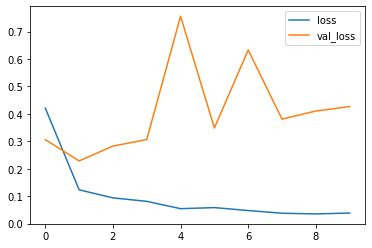

In [ ]:
history[["loss","val_loss"]].plot()

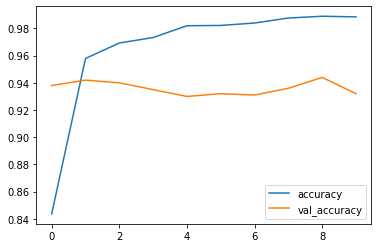

In [ ]:
history[["accuracy","val_accuracy"]].plot()

In [ ]:
ann_prediction = model_ann.predict(X_test_new)

In [ ]:
ann_pred = np.argmax(ann_prediction,axis=1)

In [ ]:
confusion_matrix(y_test,ann_pred)

array([[ 14,   0,  10],
       [  1,  13,  25],
       [ 14,  21, 902]], dtype=int64)

### F1 score

In [ ]:
f1_score(y_test,ann_pred,average=None)

array([0.52830189, 0.35616438, 0.96264674])

# LSTM with word Embedding

In [ ]:
data_train = df_train[["reviews.text","sentiment"]]
X_test = df_test["reviews.text"]
y_test = df_test_hidden["sentiment"]

In [ ]:
y_test = y_test.map({"Positive":2,"Negative":0,"Neutral":1})

In [ ]:
X = data_train["reviews.text"]
y = data_train["sentiment"]

In [ ]:
y = y.map({"Positive":2,"Negative":0,"Neutral":1})

In [ ]:
X.head()

0    Purchased on Black FridayPros - Great Price (e...
1    I purchased two Amazon in Echo Plus and two do...
2    Just an average Alexa option. Does show a few ...
3    very good product. Exactly what I wanted, and ...
4    This is the 3rd one I've purchased. I've bough...
Name: reviews.text, dtype: object

### gensim preprocess

In [ ]:
X = X.apply(gensim.utils.simple_preprocess)

In [ ]:
X.head()

0    [purchased, on, black, fridaypros, great, pric...
1    [purchased, two, amazon, in, echo, plus, and, ...
2    [just, an, average, alexa, option, does, show,...
3    [very, good, product, exactly, what, wanted, a...
4    [this, is, the, rd, one, ve, purchased, ve, bo...
Name: reviews.text, dtype: object

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=.25,random_state=23)

In [ ]:
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((3000,), (1000,), (3000,), (1000,))

### Tokenizer

In [ ]:
max_vocab_size = 20000

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab_size)

In [ ]:
tokenizer.fit_on_texts(X)

### word to sequence

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

In [ ]:
word2index = tokenizer.word_index

In [ ]:
word2index

{'the': 1,
 'it': 2,
 'to': 3,
 'and': 4,
 'for': 5,
 'is': 6,
 'my': 7,
 'this': 8,
 'great': 9,
 'with': 10,
 'of': 11,
 'tablet': 12,
 'on': 13,
 'that': 14,
 'in': 15,
 'have': 16,
 'you': 17,
 'use': 18,
 'love': 19,
 'was': 20,
 'but': 21,
 'so': 22,
 'can': 23,
 'as': 24,
 'easy': 25,
 'not': 26,
 'very': 27,
 'kindle': 28,
 'bought': 29,
 'one': 30,
 'echo': 31,
 'amazon': 32,
 'good': 33,
 'she': 34,
 'up': 35,
 'has': 36,
 'all': 37,
 'are': 38,
 'we': 39,
 'like': 40,
 'alexa': 41,
 'screen': 42,
 'be': 43,
 'loves': 44,
 'an': 45,
 'would': 46,
 'price': 47,
 'product': 48,
 'they': 49,
 'more': 50,
 'just': 51,
 'kids': 52,
 'fire': 53,
 'or': 54,
 'old': 55,
 'at': 56,
 'if': 57,
 'had': 58,
 'music': 59,
 'from': 60,
 'when': 61,
 'well': 62,
 'apps': 63,
 'do': 64,
 'he': 65,
 'me': 66,
 'get': 67,
 'her': 68,
 'works': 69,
 'much': 70,
 'show': 71,
 'than': 72,
 'device': 73,
 'really': 74,
 'books': 75,
 'time': 76,
 'read': 77,
 'purchased': 78,
 'games': 79,
 'play'

In [ ]:
len(word2index)

4775

In [ ]:
total_vocabulary = len(word2index)

In [ ]:
tokenizer.word_counts

OrderedDict([('purchased', 262),
             ('on', 975),
             ('black', 50),
             ('fridaypros', 1),
             ('great', 1289),
             ('price', 381),
             ('even', 133),
             ('off', 103),
             ('sale', 47),
             ('very', 636),
             ('powerful', 11),
             ('and', 3988),
             ('fast', 86),
             ('with', 1234),
             ('quad', 3),
             ('core', 3),
             ('processors', 1),
             ('amazing', 87),
             ('soundwell', 1),
             ('builtcons', 1),
             ('amazon', 568),
             ('ads', 19),
             ('need', 161),
             ('this', 2103),
             ('to', 3990),
             ('subsidize', 1),
             ('the', 5365),
             ('tablet', 1057),
             ('will', 222),
             ('remove', 8),
             ('adds', 13),
             ('if', 327),
             ('you', 870),
             ('pay', 27),
             ('them', 241),
 

### padding

In [ ]:
X_train_pad = pad_sequences(X_train_seq,padding="pre",truncating="pre")

In [ ]:
T = X_train_pad.shape[1]
T

1492

In [ ]:
X_valid_pad = pad_sequences(X_valid_seq,padding="pre",truncating="pre",maxlen=T)      

In [ ]:
X_valid_pad.shape

(1000, 1492)

# Model Building

In [ ]:
i = Input(shape=(T,))                       #input layer

x = Embedding(total_vocabulary+1,20)(i)     #embedding layer

x = LSTM(32,return_sequences=True)(x)      
x = GlobalMaxPooling1D()(x)

x = Dense(64)(x)
x = Dropout(0.3)(x)

x = Dense(3,activation="softmax")(x)

model = Model(i,x)

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1492)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1492, 20)          95520     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1492, 32)          6784      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195   

In [ ]:
model.fit(X_train_pad,y_train,validation_data=(X_valid_pad,y_valid),epochs=10)

Epoch 1/10
94/94 [==============================] - 112s 1s/step - loss: 0.6435 - accuracy: 0.9035 - val_loss: 0.2803 - val_accuracy: 0.9370
Epoch 2/10
94/94 [==============================] - 101s 1s/step - loss: 0.2645 - accuracy: 0.9449 - val_loss: 0.2800 - val_accuracy: 0.9370
Epoch 3/10
94/94 [==============================] - 101s 1s/step - loss: 0.2781 - accuracy: 0.9368 - val_loss: 0.2627 - val_accuracy: 0.9370
Epoch 4/10
94/94 [==============================] - 53s 559ms/step - loss: 0.2396 - accuracy: 0.9390 - val_loss: 0.2449 - val_accuracy: 0.9370
Epoch 5/10
94/94 [==============================] - 49s 519ms/step - loss: 0.1748 - accuracy: 0.9361 - val_loss: 0.2559 - val_accuracy: 0.9370
Epoch 6/10
94/94 [==============================] - 49s 525ms/step - loss: 0.1295 - accuracy: 0.9455 - val_loss: 0.2684 - val_accuracy: 0.9340
Epoch 7/10
94/94 [==============================] - 49s 526ms/step - loss: 0.0908 - accuracy: 0.9609 - val_loss: 0.2834 - val_accuracy: 0.9410
Epoch

In [ ]:
history = pd.DataFrame(model.history.history)

In [ ]:
history

,loss,accuracy,val_loss,val_accuracy
0,0.425589,0.930000,0.280347,0.937
1,0.288944,0.937333,0.280034,0.937
2,0.275198,0.937333,0.262673,0.937
3,0.229492,0.937333,0.244856,0.937
4,0.165070,0.937333,0.255881,0.937
5,0.124714,0.947667,0.268361,0.934
6,0.094855,0.961333,0.283392,0.941
7,0.069746,0.968667,0.382917,0.929
8,0.052824,0.973667,0.386521,0.924
9,0.053690,0.973333,0.389238,0.921


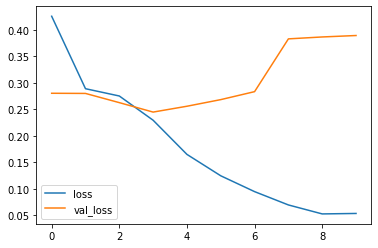

In [ ]:
history[["loss","val_loss"]].plot()

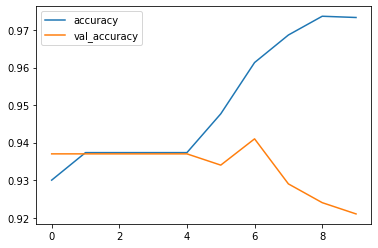

In [ ]:
history[["accuracy","val_accuracy"]].plot()

## predicting on Test set

In [ ]:
def preprocess(x_test):
    
    x_test     = x_test.apply(gensim.utils.simple_preprocess)      #preprocesing with gensim
    x_test_seq = tokenizer.texts_to_sequences(x_test)              #converting text to sequence
    x_test_pad = pad_sequences(x_test_seq)                         #padding sequence
    
    return x_test_pad

In [ ]:
X_test_pad = preprocess(X_test)

In [ ]:
model.evaluate(X_test_pad,y_test)

32/32 [==============================] - 4s 101ms/step - loss: 0.3038 - accuracy: 0.9420


[0.3037973642349243, 0.9419999718666077]

In [ ]:
pred = model.predict(X_test_pad)

In [ ]:
np.argmax(pred[0])

2

In [ ]:
y_test[0]

2

In [ ]:
y_prediction =np.argmax(pred,axis=1)

In [ ]:
confusion_matrix(y_test,y_prediction)

array([[  9,   5,  10],
       [  2,  16,  21],
       [  1,  19, 917]], dtype=int64)

### F1 score

In [ ]:
f1_score(y_test,y_prediction,average=None)

array([0.5       , 0.40506329, 0.9729443 ])

### predicting better than all other model on Neutral reviews

# creating a model with better preprocessing and Bidirectional LSTM with callbacks

## Bidirectional LSTM

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
def clean_text(text):
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if token.lemma_!="-PRON-":                  #lematizing gives output as pronouns,just avoiding that
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower()
        tokens.append(temp)
    
    cleaned = []
    for i in tokens:
        if i not in stop_words:
            review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ",i)  #urls
            review = re.sub("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"," ",review)                            #e-mail
            review = re.sub(r"[^a-zA-Z ]"," ",review)
            #cleaned.append(" ".join(review))
            cleaned.append(review)
    
    return cleaned

In [ ]:
X = X.apply(clean_text)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=.25,random_state=23)

In [ ]:
max_vocab_size = 20000

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab_size)

In [ ]:
tokenizer.fit_on_texts(X)

In [ ]:
max_vocab_size = len(tokenizer.word_counts)

In [ ]:
max_vocab_size

3671

In [ ]:
word_index = tokenizer.word_index
word_index

{'love': 1,
 'great': 2,
 'use': 3,
 'tablet': 4,
 'buy': 5,
 'easy': 6,
 'good': 7,
 ' ': 8,
 'not': 9,
 'kindle': 10,
 'echo': 11,
 'amazon': 12,
 'like': 13,
 'work': 14,
 'purchase': 15,
 'product': 16,
 'read': 17,
 'kid': 18,
 'alexa': 19,
 'screen': 20,
 'price': 21,
 'app': 22,
 'old': 23,
 'play': 24,
 'book': 25,
 'device': 26,
 'fire': 27,
 '  ': 28,
 'time': 29,
 'year': 30,
 'music': 31,
 'need': 32,
 'light': 33,
 'game': 34,
 'want': 35,
 'sound': 36,
 'set': 37,
 'gift': 38,
 'video': 39,
 '   ': 40,
 'home': 41,
 'thing': 42,
 'new': 43,
 'recommend': 44,
 'enjoy': 45,
 'nice': 46,
 'lot': 47,
 'perfect': 48,
 'look': 49,
 'feature': 50,
 'daughter': 51,
 'size': 52,
 'able': 53,
 'speaker': 54,
 'quality': 55,
 'son': 56,
 'plus': 57,
 'christmas': 58,
 'little': 59,
 'battery': 60,
 'come': 61,
 'charge': 62,
 'watch': 63,
 'family': 64,
 'control': 65,
 'happy': 66,
 'child': 67,
 'day': 68,
 'smart': 69,
 'fun': 70,
 'turn': 71,
 'download': 72,
 'small': 73,
 'wif

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

In [ ]:
X_train_pad = pad_sequences(X_train_seq)

In [ ]:
X_train_pad.shape

(3000, 631)

In [ ]:
seq_length = X_train_pad.shape[1]

In [ ]:
seq_length

631

In [ ]:
X_valid_pad = pad_sequences(X_valid_seq,maxlen=seq_length)

In [ ]:
X_valid_pad.shape

(1000, 631)

In [ ]:
i = Input(shape=(seq_length,))                       #input layer

x = Embedding(max_vocab_size+1,20)(i) #embedding layer

x = Bidirectional(LSTM(32,return_sequences=True))(x)

x = Bidirectional(LSTM(64,return_sequences=True))(x)      
x = Flatten()(x)

x = Dense(128)(x)
x = Dropout(0.3)(x)

x = Dense(32)(x)
x = Dropout(0.3)(x)

x = Dense(3,activation="softmax")(x)

model = Model(i,x)

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 631)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 631, 20)           73440     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 631, 64)           13568     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 631, 128)          66048     
_________________________________________________________________
flatten_1 (Flatten)          (None, 80768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10338432  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

### Early stopping

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)

In [ ]:
model.fit(X_train_pad,y_train,validation_data=(X_valid_pad,y_valid),epochs=20,callbacks=early_stop)

Epoch 1/20
94/94 [==============================] - 97s 910ms/step - loss: 0.4757 - accuracy: 0.8902 - val_loss: 0.2699 - val_accuracy: 0.9380
Epoch 2/20
94/94 [==============================] - 81s 863ms/step - loss: 0.2624 - accuracy: 0.9343 - val_loss: 0.3169 - val_accuracy: 0.8940
Epoch 3/20
94/94 [==============================] - 86s 917ms/step - loss: 0.1322 - accuracy: 0.9514 - val_loss: 0.2605 - val_accuracy: 0.9380
Epoch 4/20
94/94 [==============================] - 84s 891ms/step - loss: 0.0624 - accuracy: 0.9805 - val_loss: 0.4109 - val_accuracy: 0.9390
Epoch 5/20
94/94 [==============================] - 78s 834ms/step - loss: 0.0336 - accuracy: 0.9890 - val_loss: 0.5211 - val_accuracy: 0.9070
Epoch 6/20
94/94 [==============================] - 78s 831ms/step - loss: 0.0272 - accuracy: 0.9915 - val_loss: 0.6300 - val_accuracy: 0.9410


In [ ]:
loss = pd.DataFrame(model.history.history)

In [ ]:
loss

,loss,accuracy,val_loss,val_accuracy
0,0.380522,0.926000,0.269931,0.938
1,0.230611,0.936333,0.316908,0.894
2,0.130408,0.956667,0.260527,0.938
3,0.065964,0.978667,0.410947,0.939
4,0.036570,0.987333,0.521086,0.907
5,0.032830,0.989333,0.630030,0.941


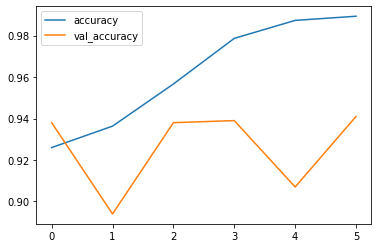

In [ ]:
loss[["accuracy","val_accuracy"]].plot()

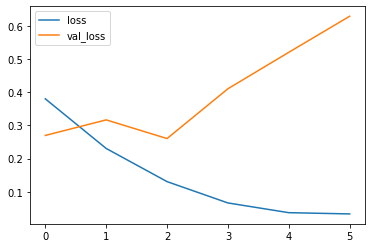

In [ ]:
loss[["loss","val_loss"]].plot()

In [ ]:
def preprocess(x_test):
    
    x_test     = x_test.apply(clean_text)      #preprocesing with gensim
    x_test_seq = tokenizer.texts_to_sequences(x_test)              #converting text to sequence
    x_test_pad = pad_sequences(x_test_seq)                         #padding sequence
    
    return x_test_pad

In [ ]:
X_test_pad = preprocess(X_test)

In [ ]:
X_test_pad.shape

(1000, 631)

In [ ]:
pred = model.predict(X_test_pad)

In [ ]:
prediction = np.argmax(pred,axis=1)

In [ ]:
confusion_matrix(y_test,prediction)

array([[  7,   3,  14],
       [  1,   7,  31],
       [  0,   8, 929]], dtype=int64)

In [ ]:
accuracy_score(y_test,prediction)

0.943

### F1 score

In [ ]:
f1_score(y_test,prediction,average=None)

array([0.4375    , 0.24561404, 0.97226583])

### performance reduced with callbacks,since callback set on accuracy

# Model with GRU 

In [ ]:
i = Input(shape=(seq_length,))                       #input layer

x = Embedding(max_vocab_size+1,20)(i) #embedding layer

x = Bidirectional(GRU(32,return_sequences=True,return_state=True))(x)

x = Bidirectional(GRU(32,return_sequences=True))(x)      
x = GlobalMaxPooling1D()(x)

x = Dense(128)(x)
x = Dropout(0.3)(x)

x = Dense(32)(x)
x = Dropout(0.3)(x)

x = Dense(3,activation="softmax")(x)

model = Model(i,x)

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 631)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 631, 20)      73440       input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional [(None, 631, 64), (N 10368       embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 631, 64)      18816       bidirectional_10[0][0]           
                                                                 bidirectional_10[0][1]     

### Early stopping

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

In [ ]:
model.fit(X_train_pad,y_train,validation_data=(X_valid_pad,y_valid),epochs=20,callbacks=early_stop)

Epoch 1/20
94/94 [==============================] - 68s 638ms/step - loss: 0.4724 - accuracy: 0.9333 - val_loss: 0.2707 - val_accuracy: 0.9370
Epoch 2/20
94/94 [==============================] - 63s 671ms/step - loss: 0.2437 - accuracy: 0.9434 - val_loss: 0.2463 - val_accuracy: 0.9370
Epoch 3/20
94/94 [==============================] - 59s 628ms/step - loss: 0.1276 - accuracy: 0.9515 - val_loss: 0.2222 - val_accuracy: 0.9360
Epoch 4/20
94/94 [==============================] - 61s 650ms/step - loss: 0.0816 - accuracy: 0.9668 - val_loss: 0.2873 - val_accuracy: 0.9280
Epoch 5/20
94/94 [==============================] - 57s 610ms/step - loss: 0.0519 - accuracy: 0.9805 - val_loss: 0.3875 - val_accuracy: 0.9290
Epoch 6/20
94/94 [==============================] - 57s 602ms/step - loss: 0.0466 - accuracy: 0.9799 - val_loss: 0.6947 - val_accuracy: 0.9390
Epoch 7/20
94/94 [==============================] - 58s 612ms/step - loss: 0.0833 - accuracy: 0.9700 - val_loss: 0.4362 - val_accuracy: 0.9250

In [ ]:
loss = pd.DataFrame(model.history.history)

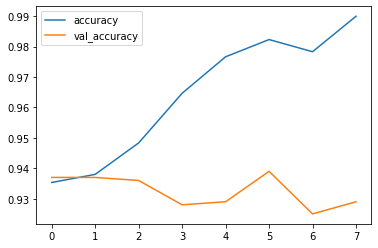

In [ ]:
loss[["accuracy","val_accuracy"]].plot()

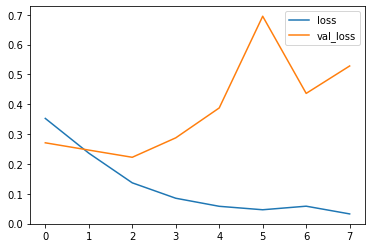

In [ ]:
loss[["loss","val_loss"]].plot()

In [ ]:
prediction = model.predict(X_test_pad)
prediction = np.argmax(prediction,axis=1)

In [ ]:
confusion_matrixsion_matrix(y_test,prediction)

array([[ 10,   1,  13],
       [  7,   5,  27],
       [  5,   4, 928]], dtype=int64)

In [ ]:
f1_score(y_test,prediction,average=None)

array([0.43478261, 0.20408163, 0.97427822])

## LSTM performed better than GRU

# creating word2vec vectors on dataset using Gensim

### using all the reviews from training and test set to create word vectors innorder to get better result

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
def clean_text(text):
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if token.lemma_!="-PRON-":                  #lematizing gives output as pronouns,just avoiding that
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower()
        tokens.append(temp)
    
    cleaned = []
    for i in tokens:
        if i not in stop_words:
            review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ",i)  #urls
            review = re.sub("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"," ",review)                            #e-mail
            review = re.sub(r"[^a-zA-Z ]"," ",review)
            #cleaned.append(" ".join(review))
            cleaned.append(review)
    
    return cleaned

In [ ]:
X

0       Purchased on Black FridayPros - Great Price (e...
1       I purchased two Amazon in Echo Plus and two do...
2       Just an average Alexa option. Does show a few ...
3       very good product. Exactly what I wanted, and ...
4       This is the 3rd one I've purchased. I've bough...
                              ...                        
3995    It‚Äôs fun for the family to play with, but it...
3996    I love the Kindle, it is a great product. It r...
3997    I was looking for a blutooth speaker to use wi...
3998    This is the second Amazon Fire 7 tablet I have...
3999    very satisfied with tablet, very fast and effi...
Name: reviews.text, Length: 4000, dtype: object

In [ ]:
X_test

0      Amazon kindle fire has a lot of free app and c...
1      The Echo Show is a great addition to the Amazo...
2      Great value from Best Buy. Bought at Christmas...
3      I use mine for email, Facebook ,games and to g...
4      This is a fantastic item & the person I bought...
                             ...                        
995    We love Alexa! Love being able to watch news b...
996    Speaker is pretty loud and I love that I can t...
997    Bought 2 of these for my 6 and 8 yr old and it...
998    Was told by sales person I could come back in ...
999    I purchased this as a gift for my mother. Her ...
Name: reviews.text, Length: 1000, dtype: object

In [ ]:
full_df = pd.concat([X,X_test],axis=0).reset_index(drop=True)

In [ ]:
full_df.shape

(5000,)

In [ ]:
cleaned_df = full_df.apply(clean_text)

In [ ]:
cleaned_df

0       [purchase, black, fridaypros, great, price, sa...
1       [purchase, amazon, echo, plus, dot, plus, fire...
2        [average, alexa, option, thing, screen, limited]
3             [good, product, exactly, want, good, price]
4       [ rd, purchase, buy, niece, case, compare, hol...
                              ...                        
4995    [love, alexa, love, able, watch, news, briefin...
4996    [speaker, pretty, loud, love, downside, hold, ...
4997    [buy,  ,  ,  , yr, old, come,   , gb, storage,...
4998    [tell, sale, person, come, week, receipt,   , ...
4999    [purchase, gift, mother, tablet, love, easy, n...
Name: reviews.text, Length: 5000, dtype: object

In [ ]:
model = gensim.models.Word2Vec(cleaned_df,window=5, min_count=2, workers=4)

In [ ]:
model.build_vocab(cleaned_df)

In [ ]:
model.corpus_count

5000

In [ ]:
model.corpus_total_words

68459

In [ ]:
model.epochs

5

In [ ]:
model.train(cleaned_df,total_examples=model.corpus_count,total_words=model.corpus_total_words,epochs=model.epochs)

(252411, 342295)

In [ ]:
model.wv["good"]

array([-2.16782019e-01,  1.94323555e-01,  6.48025870e-02, -1.32623583e-01,
        1.14745334e-01, -7.53639519e-01,  1.70355439e-01,  1.04976463e+00,
       -3.41976255e-01, -4.35155720e-01, -1.10926762e-01, -5.63753068e-01,
       -1.15776166e-01,  3.52179170e-01,  2.16354415e-01, -4.04606819e-01,
        3.67594153e-01, -3.81852567e-01,  2.02412084e-02, -9.05079126e-01,
        2.87547231e-01,  6.50917292e-02,  9.54926386e-02, -2.06387907e-01,
       -2.30192527e-05, -2.65334565e-02, -3.68528545e-01, -4.54837114e-01,
       -2.78419912e-01,  5.49284779e-02,  5.27755022e-01,  6.60993308e-02,
        1.30842254e-02, -4.74860728e-01, -2.43804991e-01,  6.00940883e-01,
        5.66023141e-02, -5.20829976e-01, -8.08620155e-02, -8.79477918e-01,
       -2.59448420e-02, -5.28933227e-01,  3.80593725e-02, -5.38559072e-02,
        3.78786981e-01, -1.94403201e-01, -4.03733164e-01, -1.79085761e-01,
        2.94269681e-01,  1.44686207e-01,  1.28392130e-01, -2.82082081e-01,
       -1.12292401e-01,  

In [ ]:
model.wv.similarity(w1="awesome",w2="good")

0.98963284

In [ ]:
model.wv.similarity(w1="storage",w2="black")

0.9966698

In [ ]:
model.wv.similarity(w1="kind",w2="alexa")

0.9516631

## The dataset is still so small to train good word vectors, these vectors  are not very good. So using pretrained word vectors

# pretrained Google wordvectors

In [ ]:
import os
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

In [ ]:
os.listdir()

['.ipynb_checkpoints',
 'catboost_info',
 'Deep NLP.ipynb',
 'gensim_word2vec.ipynb',
 'GoogleNews-vectors-negative300.bin',
 'Retail.ipynb',
 'test_data.csv',
 'test_data_hidden.csv',
 'train_data.csv',
 'wordvector_model.model',
 'word_vectors.h5']

In [ ]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

### pretrained vector for "BAD"

In [ ]:
model["bad"]

array([ 0.06298828,  0.12451172,  0.11328125,  0.07324219,  0.03881836,
        0.07910156,  0.05078125,  0.171875  ,  0.09619141,  0.22070312,
       -0.04150391, -0.09277344, -0.02209473,  0.14746094, -0.21582031,
        0.15234375,  0.19238281, -0.05078125, -0.11181641, -0.3203125 ,
        0.00506592,  0.15332031, -0.02563477, -0.0234375 ,  0.36328125,
        0.20605469,  0.04760742, -0.02624512,  0.09033203,  0.00457764,
       -0.15332031,  0.06591797,  0.3515625 , -0.12451172,  0.03015137,
        0.16210938,  0.00242615, -0.02282715,  0.02978516,  0.00531006,
        0.25976562, -0.22460938,  0.29492188, -0.18066406,  0.07910156,
        0.02282715,  0.12109375, -0.17382812, -0.03735352, -0.06933594,
       -0.21972656,  0.1875    , -0.03320312, -0.06225586, -0.04492188,
        0.11621094, -0.23339844, -0.11669922,  0.09814453, -0.11962891,
        0.13964844,  0.28710938, -0.26953125, -0.05493164,  0.03112793,
       -0.05029297,  0.1328125 , -0.01831055, -0.37695312, -0.06

In [ ]:
model["bad"].shape

(300,)

In [ ]:
seq_length

631

In [ ]:
vocab_limit = 20000

In [ ]:
max_vocab_size

3671

In [ ]:
EMBEDDING_DIM = 300

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(vocab_limit,max_vocab_size + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, index in word_index.items():
    if index >= vocab_limit:
        continue
    if word in model.key_to_index:
      embedding_vector = model[word]
      embedding_vector = np.array(embedding_vector)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

Preparing embedding matrix.
(3672, 300)


In [ ]:
model = Sequential()
model.add(Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=seq_length,
                            trainable=False))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 631, 300)          1101600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 189300)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               96922112  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [ ]:
model.fit(X_train_pad, y_train,epochs=1,validation_data=(X_valid_pad, y_valid))

### Due to low ram capacity, system keep on getting hang while training. So couldnt train the model

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

**optional task**

# Topic modeling

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import gensim
import spacy

In [ ]:
df = pd.read_csv("train_data.csv")
reviews = df["reviews.text"]

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
from spacy.lang.en import STOP_WORDS
from string import punctuation

In [ ]:
stop_words = list(STOP_WORDS)+list(punctuation)

In [ ]:
stop_words.remove("not")

In [ ]:
def text_preprocess(text):
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        if token.lemma_!="-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower()
        tokens.append(temp)
        
    cleaned = []
    for i in tokens:
        if i not in stop_words:
            cleaned.append(i)
    return cleaned

In [ ]:
cleaned_reviews = reviews.apply(text_preprocess)

In [ ]:
dictionary = gensim.corpora.Dictionary(cleaned_reviews)

In [ ]:
dictionary.filter_extremes(no_above=1,no_below=0.1)

In [ ]:
print(dictionary)

Dictionary(3806 unique tokens: ['-amazon', '15.inability', 'able', 'access', 'accomplish']...)


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in cleaned_reviews]

In [ ]:
lda_model = gensim.models.LdaModel(bow_corpus,num_topics=10,id2word=dictionary,passes=10)

In [ ]:
lda = gensim.models.ldamodel.LdaModel(bow_corpus,num_topics=10,id2word=dictionary)

In [ ]:
for idx,topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}, \nwords: {topic}")
    print("\n")

Topic: 0, 
words: 0.045*"good" + 0.040*"great" + 0.029*"use" + 0.028*"price" + 0.027*"product" + 0.025*"tablet" + 0.021*"kindle" + 0.020*"easy" + 0.018*"recommend" + 0.017*"buy"


Topic: 1, 
words: 0.057*"kindle" + 0.030*"book" + 0.027*"read" + 0.025*"easy" + 0.023*"buy" + 0.019*"use" + 0.015*"love" + 0.014*"charge" + 0.013*"old" + 0.011*"time"


Topic: 2, 
words: 0.039*"screen" + 0.031*"kindle" + 0.024*"light" + 0.024*"read" + 0.023*"small" + 0.017*"like" + 0.017*"fit" + 0.015*"touch" + 0.014*"book" + 0.012*"easy"


Topic: 3, 
words: 0.052*"great" + 0.047*"tablet" + 0.033*"not" + 0.030*"work" + 0.029*"kid" + 0.027*"amazon" + 0.019*"price" + 0.019*"app" + 0.017*"use" + 0.013*"prime"


Topic: 4, 
words: 0.048*"echo" + 0.029*"use" + 0.029*"love" + 0.025*"great" + 0.023*"sound" + 0.020*"alexa" + 0.017*"speaker" + 0.014*"music" + 0.013*"buy" + 0.013*"easy"


Topic: 5, 
words: 0.029*"not" + 0.023*"charge" + 0.021*"kindle" + 0.017*"like" + 0.015*"page" + 0.014*"button" + 0.014*"screen" + 0.0

In [ ]:
import pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
import pyLDAvis.gensim_models

In [ ]:
vis = pyLDAvis.gensim_models.prepare(topic_model=lda,corpus=bow_corpus,dictionary=dictionary)

ImportError: cannot import name 'FuncType' from 'pandas._typing' (C:\Users\Vishnu\anaconda3\lib\site-packages\pandas\_typing.py)

### getting this error "cannot import name 'FuncType' from 'pandas._typing' (C:\Users\Vishnu\anaconda3\lib\site-packages\pandas\_typing.py)"

# LSTM with word embedding performed better than other models, 
# xgboost performed well in ML models
# since model could't train with wordvectors failed to see the scores